In [1]:
pip install imblearn

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.3/199.3 kB 34.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.2/31.2 MB 79.6 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


## This Notebook is for the research question 3: Predict whether the applicant would be offered a position
### 0. Import the library and read the dataframe

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import datetime
import imblearn
from sklearn.preprocessing import scale
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.datasets import make_classification
pd.set_option('display.max_columns', 300) # allow us read the full picture of dataframe
pd.set_option('display.max_rows', 300) # allow us read the full picture of dataframe

In [11]:
data = pd.read_pickle("df/data_clean.pkl") 

data.head()

,Department,Applicant ID,City - Address line 4,Programme,Latest Decision,Latest Decision Date,Country of Birth,Domicile,Nationality,Country of Institution,Grade on application,uob_alum,home_oversea,master_prev,distance,Institution,Institution_app_num,Fee Status,School,A1 Created date,A1 Updated date,A2 Created date,Decision Date,Response Date,Days at Admissions Review,Days in School,Days at Decision Stage,Total Days Admissions,TOTAL Days,Response days,decision_since_Sep01,A1C_since_Sep01,A1U_since_Sep01,A2C_since_Sep01,Response_since_Sep01,funding,Decision_C,Decision_R,Decision_U,Status,Qual_Name,Ielts_Overall,Ielts_Listening,Ielts_Reading,Ielts_Writing,Ielts_Speaking,Toefl_Overall,Toefl_Listening,Toefl_Reading,Toefl_Writing,Toefl_Speaking,PTE_Overall,PTE_Listening,PTE_Reading,PTE_Writing,PTE_Speaking,eng_type,multi_app,Prog Code,Prog Desc,Date Started,offered,offer_num,accepted,Institution_offer_num,Insti_weight
0,COMPUTER SCI,2305538,BENGALURU,MSc Computer Science FT,Conditional Offer - waiting for response,2021-02-25,NaN,NaN,NaN,IndiaIndia,8.4,0,1,0,8000.0,PES University,12.0,O,Computer Science,2020-11-30,2021-01-28,2021-02-05,2021-02-25,NaT,59.0,8.0,20.0,79.0,87.0,0.0,177.0,90.0,149.0,157.0,0.0,0.0,1.0,0.0,0.0,Active,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,NaN,NaN,NaN,1,1.0,0,9.0,0.750000
1,BUSINESS,2376697,KHAJRANA INDORE,MSc Adv Eng Man (Constr Man)FT,Conditional Offer - waiting for response,2021-06-10,India,India,India,IndiaIndia,7.42 CGPA,0,1,0,8000.0,ACROPOLIS INSTITUTE OF TECHNOLOGY & RESEARCH,1.0,O,Business School,2021-05-24,2021-06-10,2021-02-05,2021-06-10,NaT,17.0,0.0,0.0,17.0,17.0,0.0,282.0,265.0,282.0,0.0,0.0,0.0,1.0,0.0,0.0,Active,IELTS (International English Language Testing ...,8.0,8.0,9.0,6.5,7.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,NaN,NaN,NaN,1,1.0,0,1.0,1.000000
2,COMPUTER SCI,2374445,"BARWAHA , KHARGONE",MSc Artific Int & Mach Lear FT,Rejected at stage 1,2021-06-25,India,India,India,IndiaIndia,73.50%,0,1,0,8000.0,"AISSM'S Institute of Information Technology, Pune",1.0,O,Computer Science,2021-05-12,2021-06-25,2021-02-05,2021-06-25,NaT,44.0,0.0,0.0,44.0,44.0,0.0,297.0,253.0,297.0,0.0,0.0,0.0,0.0,1.0,0.0,Active,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,NaN,NaN,NaN,0,NaN,0,NaN,NaN
3,EEC ENG,2263436,CHANGCHUN CITY,MSc Elec + Computer Eng FT,Withdrawn,2020-11-06,China,China,China,China,79.13%,0,1,0,8000.0,Guizhou University,5.0,O,Elec Elec and System Eng;Elec Elec and Sys Eng...,2020-10-06,2020-11-06,2021-02-05,2020-11-06,2006-11-20,31.0,0.0,0.0,31.0,31.0,0.0,66.0,35.0,66.0,0.0,66.0,0.0,1.0,0.0,0.0,Withdrawn,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,NaN,NaN,NaN,1,1.0,0,5.0,1.000000
4,COMPUTER SCI,2295129,"WEIHAI, SHANDONG",MSc Artific Int & Mach Lear FT,Conditional Offer - waiting for response,2021-03-18,China,China,China,ChinaChina,,0,1,0,8000.0,Shandong University,9.0,O,Computer Science,2020-11-16,2021-02-15,2021-02-15,2021-03-18,2006-11-20,91.0,0.0,31.0,122.0,122.0,0.0,198.0,76.0,167.0,167.0,0.0,0.0,1.0,0.0,0.0,Active,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2,NaN,NaN,NaN,1,2.0,0,4.0,0.444444


In [12]:
data.columns

Index(['Department', 'Applicant ID', 'City - Address line 4', 'Programme',
       'Latest Decision', 'Latest Decision Date', 'Country of Birth',
       'Domicile', 'Nationality', 'Country of Institution',
       'Grade on application', 'uob_alum', 'home_oversea', 'master_prev',
       'distance', 'Institution', 'Institution_app_num', 'Fee Status',
       'School', 'A1 Created date', 'A1 Updated date', 'A2 Created date',
       'Decision Date', 'Response Date', 'Days at Admissions Review',
       'Days in School', 'Days at Decision Stage', 'Total Days Admissions',
       'TOTAL Days', 'Response days', 'decision_since_Sep01',
       'A1C_since_Sep01', 'A1U_since_Sep01', 'A2C_since_Sep01',
       'Response_since_Sep01', 'funding', 'Decision_C', 'Decision_R',
       'Decision_U', 'Status', 'Qual_Name', 'Ielts_Overall', 'Ielts_Listening',
       'Ielts_Reading', 'Ielts_Writing', 'Ielts_Speaking', 'Toefl_Overall',
       'Toefl_Listening', 'Toefl_Reading', 'Toefl_Writing', 'Toefl_Speaking',


In [13]:
# Define the feature set (X) and target variable (Y)
X_all = data.copy()

X_all['offered'] = X_all['offered'].astype('category')

X = X_all.loc[:,['Applicant ID', 'School', 'Programme',
                 'uob_alum', 'home_oversea', 'master_prev', 'distance', 'funding', 
                 'Days at Admissions Review', 'Days in School', 'Days at Decision Stage', 'Total Days Admissions', 'TOTAL Days', 
                 'decision_since_Sep01', 'A1C_since_Sep01', 'A1U_since_Sep01', 'A2C_since_Sep01',             
                 'eng_type', 'Ielts_Overall', 'Ielts_Listening', 'Ielts_Reading', 'Ielts_Writing', 'Ielts_Speaking', 
                 'Toefl_Overall', 'Toefl_Listening', 'Toefl_Reading', 'Toefl_Writing', 'Toefl_Speaking', 
                 'PTE_Overall', 'PTE_Listening', 'PTE_Reading', 'PTE_Writing', 'PTE_Speaking', 
                 'multi_app']].copy()

X = X.fillna(method="ffill")
Y = X_all['offered']
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15604 entries, 0 to 15603
Data columns (total 34 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Applicant ID               15604 non-null  int64  
 1   School                     15604 non-null  object 
 2   Programme                  15604 non-null  object 
 3   uob_alum                   15604 non-null  int64  
 4   home_oversea               15604 non-null  int64  
 5   master_prev                15604 non-null  int64  
 6   distance                   15604 non-null  float64
 7   funding                    15604 non-null  float64
 8   Days at Admissions Review  15604 non-null  float64
 9   Days in School             15604 non-null  float64
 10  Days at Decision Stage     15604 non-null  float64
 11  Total Days Admissions      15604 non-null  float64
 12  TOTAL Days                 15604 non-null  float64
 13  decision_since_Sep01       15604 non-null  flo

In [14]:
Y.describe()

count     15604
unique        2
top           1
freq       8912
Name: offered, dtype: int64

## 2.Process the object type column
Here we have the 'School' and 'Programme' columns

### 2.1 'School' column
Use one hot encoder to create a binary column for each category

In [15]:
X['School'].nunique()

12

In [16]:
X['School'].unique()

array(['Computer Science', 'Business School',
       'Elec Elec and System Eng;Elec Elec and Sys Engineering',
       'Metallurgy and Materials', 'Civil Engineering',
       'School of Engineering;Elec Elec and Sys Engineering',
       'Mechanical Engineering', 'Physics and Astronomy',
       'Chemical Engineering', 'Mathematics', 'EPS College Hub', 'Wiley'],
      dtype=object)

In [17]:
from sklearn.preprocessing import scale
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse=False)
X[['Computer Science', 'Business School',
       'Elec Elec and System Eng;Elec Elec and Sys Engineering',
       'Metallurgy and Materials', 'Civil Engineering',
       'School of Engineering;Elec Elec and Sys Engineering',
       'Mechanical Engineering', 'Physics and Astronomy',
       'Chemical Engineering', 'Mathematics', 'Wiley', 'EPS College Hub']] = ohe.fit_transform(X['School'].values.reshape(-1,1))
print(ohe.get_feature_names_out(['School']))
X = X.drop(['School'], axis=1)

['School_Business School' 'School_Chemical Engineering'
 'School_Civil Engineering' 'School_Computer Science'
 'School_EPS College Hub'
 'School_Elec Elec and System Eng;Elec Elec and Sys Engineering'
 'School_Mathematics' 'School_Mechanical Engineering'
 'School_Metallurgy and Materials' 'School_Physics and Astronomy'
 'School_School of Engineering;Elec Elec and Sys Engineering'
 'School_Wiley']


### 2.2 'Programme' column

In [18]:
X['Programme'].nunique()

119

In [ ]:
X['Programme'].unique()

array(['MSc Computer Science FT', 'MSc Adv Eng Man (Constr Man)FT',
       'MSc Artific Int & Mach Lear FT', 'MSc Elec + Computer Eng FT',
       'MSc Data Science FT', 'MSc Human-Computer Interact FT',
       'MSc Material Sci + Engineer FT', 'MSc Cyber Security FT',
       'MSc Civil Engineering FT', 'MSc Adv Eng Man (Projec Man)FT',
       'MSc Structural Engineering (FT)', 'MSc Electric Power Systems FT',
       'MSc Rail Sys Eng+Int w Pre FT', 'MSc Adv Eng Man (Generalist)FT',
       'MSc Communications Engineer FT', 'MSc Advanced Computer Sc FT',
       'MSc Advanced Mech Eng FT', 'MSc Adv Eng Man (Operat Man)FT',
       'MSc Phys + Tech Nuc React FT', 'MSc Civil Engineering PT Dubai',
       'MSc Advanced Chemical Eng FT', 'MSc Food Safety; Hyg + Man FT',
       'MSc Global Energy Technologies and Systems FT',
       'MEng Comp Sci Sof En FT (Dub)', 'BSc Computer Sci FT (Dubai)',
       'MSc Applied Mathematics FT', 'BIA Engin Phys Sci 4Yr (Dubai)',
       'MSc MORSE FT', 'MSc R

In [ ]:
X['Programme'].unique()

array(['MSc Computer Science FT', 'MSc Adv Eng Man (Constr Man)FT',
       'MSc Artific Int & Mach Lear FT', 'MSc Elec + Computer Eng FT',
       'MSc Data Science FT', 'MSc Human-Computer Interact FT',
       'MSc Material Sci + Engineer FT', 'MSc Cyber Security FT',
       'MSc Civil Engineering FT', 'MSc Adv Eng Man (Projec Man)FT',
       'MSc Structural Engineering (FT)', 'MSc Electric Power Systems FT',
       'MSc Rail Sys Eng+Int w Pre FT', 'MSc Adv Eng Man (Generalist)FT',
       'MSc Communications Engineer FT', 'MSc Advanced Computer Sc FT',
       'MSc Advanced Mech Eng FT', 'MSc Adv Eng Man (Operat Man)FT',
       'MSc Phys + Tech Nuc React FT', 'MSc Civil Engineering PT Dubai',
       'MSc Advanced Chemical Eng FT', 'MSc Food Safety; Hyg + Man FT',
       'MSc Global Energy Technologies and Systems FT',
       'MEng Comp Sci Sof En FT (Dub)', 'BSc Computer Sci FT (Dubai)',
       'MSc Applied Mathematics FT', 'BIA Engin Phys Sci 4Yr (Dubai)',
       'MSc MORSE FT', 'MSc R

### We will apply three methods to deal with this column
1. drop this column. In the future study, the dataset can be split by programme and build different models for different programmes
2. use Ordinal Encoder to encode target labels with value between 0 and n_classes-1. Output: 1 column
3. Use One Hot Encoder. Output: n_classes columns. The dimension increase may affect a lot

#### 1.Drop the 'programme', the new feature set named X1

In [23]:
X1 = X.copy()
X1 = X1.drop(['Programme'], axis=1)

#### 2.Ordinal Encoder on the 'programme', the new feature set named X2

In [24]:
X2 = X.copy()
enc = OrdinalEncoder()
X2['Programme'] = enc.fit_transform(X2['Programme'].values.reshape(-1,1))

In [25]:
X2['Programme'].nunique()

119

#### 3.One Hot Encoder on the 'programme', the new feature set named X3

In [26]:
ohe = OneHotEncoder(sparse=False)
X3 = X.copy()
X3[['MSc Computer Science FT', 'MSc Adv Eng Man (Constr Man)FT',
       'MSc Artific Int & Mach Lear FT', 'MSc Elec + Computer Eng FT',
       'MSc Data Science FT', 'MSc Human-Computer Interact FT',
       'MSc Material Sci + Engineer FT', 'MSc Cyber Security FT',
       'MSc Civil Engineering FT', 'MSc Adv Eng Man (Projec Man)FT',
       'MSc Structural Engineering (FT)', 'MSc Electric Power Systems FT',
       'MSc Rail Sys Eng+Int w Pre FT', 'MSc Adv Eng Man (Generalist)FT',
       'MSc Communications Engineer FT', 'MSc Advanced Computer Sc FT',
       'MSc Advanced Mech Eng FT', 'MSc Adv Eng Man (Operat Man)FT',
       'MSc Phys + Tech Nuc React FT', 'MSc Civil Engineering PT Dubai',
       'MSc Advanced Chemical Eng FT', 'MSc Food Safety; Hyg + Man FT',
       'MSc Global Energy Technologies and Systems FT',
       'MEng Comp Sci Sof En FT (Dub)', 'BSc Computer Sci FT (Dubai)',
       'MSc Applied Mathematics FT', 'BIA Engin Phys Sci 4Yr (Dubai)',
       'MSc MORSE FT', 'MSc Robotics FT',
       'MSc Art Int + Comp Sc PT (Dub)', 'MSc Civil Engineering FT Dubai',
       'MSc Civ Eng and Management PT', 'MSc Geotechnical Eng + Mgt FT',
       'BIA Engineering Physical Sciences 43m Jan Dubai',
       'MSc Art Int + Comp Sc FT (Dub)',
       'MSc Advanced Chemical Engineering with Energy FT',
       'MSc Financial Engineering FT', 'MSc Nuclear Decom Waste Man FT',
       'PGCert Des Lear Env DL PT', 'BSc Art Intel and Comp Sci FT Dubai',
       'MSc Adv Eng Man (Operat Man)PT', 'MSc Civ Eng and Management FT',
       'MSc Geotechnical Eng FT',
       'MSc Advanced Chemical Eng with Bioprocessing PT',
       'MSc Computer Science PT (Dub)',
       'MSc Industrial Project Man. PT Blended Learning',
       'MSc Rail Safe + Control Sys FT',
       'MSc Advanced Chemical Eng with Bioprocessing FT',
       'MSc Electric Power Systems PT', 'MSc Formulation Engineering FT',
       'MSc Elec Pow Syst w Adv Res FT', 'MSc Computer Science FT(Dubai)',
       'MSc Road Mgt + Eng FT', 'MSc Fue Cel + Hyd Tec Blend FT',
       'MSc Adv Chem Eng w Form FT',
       'PGDip Adv Chem Eng with Healthcare Technology FT',
       'MSc Adv Eng Man (System Man)FT', 'BEng Mechanical Eng FT (Dubai)',
       'MSc Rail Sys Eng + Int PT DA', 'MSc Healthcare Technology FT',
       'MSc Advanced Chemical Eng PT', 'MSc Structural Engineering PT',
       'MSc Rail Saf+Con Sys (Flex) DL',
       'PGDip Advanced Chemical Engineering with Energy FT',
       'PGDip Geotechnical Eng FT', 'PGCert Rail Systems Eng Int FT',
       'MSc Rail System Engin Integ DL', 'MSc Mathematical Finance FT',
       'MSc Elec + Computer Eng PT',
       'MSc Civil Engineering Dubai (January) PT',
       'MSc Advanced Mech Eng PT',
       'MSc Adv Chemical Eng with Healthcare Technology PT',
       'MSc Advanced Chemical Engineering with Energy PT',
       'MSc Civil Engineering PT', 'PGDip Geotechnical Eng PT',
       'PGCert Food Safety Hyg Man PT', 'PGDip Civ Eng & Management FT',
       'MSc Nuclear Decom Waste Man PT', 'MSc Rail Sys Eng Inte DL Fixed',
       'MSc Rail Systems Engin Int FT', 'MSc Road Mgt + Eng PT',
       'PGDip Art In + Com Sc FT (Dub)', 'PGDip Computer Scien FT(Dubai)',
       'MSc Civil Engineering Part Time Fixed Duration',
       'PGDip Road Mgt + Eng PT', 'MSc Adv Eng Man (Projec Man)PT',
       'MSc Adv Eng Man (Generalist)PT', 'PGDip Rail Safe + Cont Sys FT',
       'MSc Rail Saf+Con Sys DL Fixed', 'MSc Geotechnical Eng PT',
       'MSc Adv Eng Man (Constr Man)PT', 'MSc Food Safety, Hyg + Man PT',
       'MSc Phys + Tech Nuc React PT', 'PGCert Rail Sa+Co Sy (Flex) DL',
       'MSc Adv Chem Eng with Healthcare Technology FT',
       'MSc Advanced Chemical Engineering with Form PT',
       'PGDip Advanced Chemical Eng with Bioprocessing FT',
       'MSc Civil Engineering and Manag PT Fixed Duration',
       'PGDip Civ Eng & Management PT', 'PGDip Road Mgt + Eng FT',
       'PG MC Tech Fuel Cell Char MC', 'MSc Fue Cel + Hyd Tec Blend PT',
       'MSc Rail Safe+Cont Sy w Pre FT', 'PGCert Rail Syst Eng Integ DL',
       'PGDip Advanced Chemical Eng PT', 'MSc Civil Enginee FT Jan Dubai',
       'PGDip Geotechnical Eng+Mgt FT', 'PGCert Geotechnical Eng PT',
       'MSc Geotechnical Engineering (PT; Fixed Duration)',
       'PGDip Formulation Engineering PT',
       'PG MC Fuel Cell + Hyd Tech MC', 'MSc Communications Engineer PT',
       'PGDip Healthcare Technology FT', 'PG MC Fuel Cell Elect Vehi PT',
       'PGDip Rail Systems Eng Int FT',
       'PGDip Structural Engineering (PT)', 'PGDip Civil Eng  FT (Dubai)',
       'PGDip Art In + Com Sc PT (Dub)', 'PGDip Advanced Chemical Eng FT']] = ohe.fit_transform(X3['Programme'].values.reshape(-1,1))

X3 = X3.drop(['Programme'], axis=1)

/tmp/ipykernel_148/3924403673.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X3[['MSc Computer Science FT', 'MSc Adv Eng Man (Constr Man)FT',
/tmp/ipykernel_148/3924403673.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X3[['MSc Computer Science FT', 'MSc Adv Eng Man (Constr Man)FT',
/tmp/ipykernel_148/3924403673.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis

In [27]:
X1.shape

(15604, 44)

In [28]:
X2.shape

(15604, 45)

In [29]:
X3.shape

(15604, 163)

#### Normalization

In [30]:
from sklearn.preprocessing import MinMaxScaler
X1_normalized = X4.copy()
scaler4 = MinMaxScaler() 
scaled_values = scaler4.fit_transform(X1) 
X1_normalized.loc[:,:] = scaled_values
X1_normalized.to_pickle("X4/X1_normalized.pkl") 
X1_normalized.describe()

,Applicant ID,uob_alum,home_oversea,master_prev,distance,funding,Days at Admissions Review,Days in School,Days at Decision Stage,Total Days Admissions,TOTAL Days,decision_since_Sep01,A1C_since_Sep01,A1U_since_Sep01,A2C_since_Sep01,eng_type,Ielts_Overall,Ielts_Listening,Ielts_Reading,Ielts_Writing,Ielts_Speaking,Toefl_Overall,Toefl_Listening,Toefl_Reading,Toefl_Writing,Toefl_Speaking,PTE_Overall,PTE_Listening,PTE_Reading,PTE_Writing,PTE_Speaking,multi_app,Computer Science,Business School,Elec Elec and System Eng;Elec Elec and Sys Engineering,Metallurgy and Materials,Civil Engineering,School of Engineering;Elec Elec and Sys Engineering,Mechanical Engineering,Physics and Astronomy,Chemical Engineering,Mathematics,Wiley,EPS College Hub
count,15604.000000,15604.000000,15604.000000,15604.000000,15604.000000,15604.000000,15604.000000,15604.000000,15604.000000,15604.000000,15604.000000,15604.000000,15604.000000,15604.000000,15604.000000,15604.000000,15604.000000,15604.000000,15604.000000,15604.000000,15604.000000,15604.000000,15604.000000,15604.000000,15604.000000,15604.000000,15604.000000,15604.000000,15604.000000,15604.000000,15604.000000,15604.000000,15604.000000,15604.000000,15604.000000,15604.000000,15604.000000,15604.000000,15604.000000,15604.000000,15604.000000,15604.000000,15604.000000,15604.000000
mean,0.890262,0.007049,0.947706,0.062676,0.453993,0.031338,0.069873,0.017634,0.021998,0.083634,0.094161,0.333285,0.211622,0.287171,0.132772,0.145988,0.018982,0.031815,0.031523,0.026012,0.026905,0.023059,0.009858,0.010293,0.009301,0.008974,0.003234,0.003206,0.003256,0.003363,0.003419,0.041368,0.089528,0.071905,0.084914,0.460715,0.016470,0.079467,0.078121,0.037939,0.032492,0.009741,0.034863,0.003845
std,0.061273,0.083667,0.222627,0.242387,0.101300,0.174235,0.061475,0.037344,0.043874,0.068135,0.072431,0.143860,0.151566,0.159374,0.181242,0.201594,0.038754,0.052332,0.051987,0.043313,0.044332,0.105969,0.047025,0.048954,0.044628,0.042888,0.050236,0.049523,0.050332,0.051914,0.053055,0.118181,0.285514,0.258338,0.278763,0.498470,0.127279,0.270475,0.268370,0.191055,0.177308,0.098218,0.183438,0.061892
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.883821,0.000000,1.000000,0.000000,0.476992,0.000000,0.028264,0.000000,0.000000,0.033467,0.038513,0.240000,0.086826,0.191679,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.900234,0.000000,1.000000,0.000000,0.476992,0.000000,0.060565,0.002092,0.000000,0.070950,0.083665,0.347692,0.177395,0.291233,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.922118,0.000000,1.000000,0.000000,0.476992,0.000000,0.106326,0.027197,0.040104,0.120482,0.131474,0.441538,0.317365,0.399703,0.283784,0.333333,0.053571,0.088235,0.088235,0.075342,0.076389,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000

In [31]:
X2_normalized = X2.copy()
scaler5 = MinMaxScaler() 
scaled_values = scaler5.fit_transform(X2) 
X2_normalized.loc[:,:] = scaled_values
X2_normalized.to_pickle("X5/X2_normalized.pkl") 
X2_normalized.describe()

,Applicant ID,Programme,uob_alum,home_oversea,master_prev,distance,funding,Days at Admissions Review,Days in School,Days at Decision Stage,Total Days Admissions,TOTAL Days,decision_since_Sep01,A1C_since_Sep01,A1U_since_Sep01,A2C_since_Sep01,eng_type,Ielts_Overall,Ielts_Listening,Ielts_Reading,Ielts_Writing,Ielts_Speaking,Toefl_Overall,Toefl_Listening,Toefl_Reading,Toefl_Writing,Toefl_Speaking,PTE_Overall,PTE_Listening,PTE_Reading,PTE_Writing,PTE_Speaking,multi_app,Computer Science,Business School,Elec Elec and System Eng;Elec Elec and Sys Engineering,Metallurgy and Materials,Civil Engineering,School of Engineering;Elec Elec and Sys Engineering,Mechanical Engineering,Physics and Astronomy,Chemical Engineering,Mathematics,Wiley,EPS College Hub
count,15604.000000,15604.000000,15604.000000,15604.000000,15604.000000,15604.000000,15604.000000,15604.000000,15604.000000,15604.000000,15604.000000,15604.000000,15604.000000,15604.000000,15604.000000,15604.000000,15604.000000,15604.000000,15604.000000,15604.000000,15604.000000,15604.000000,15604.000000,15604.000000,15604.000000,15604.000000,15604.000000,15604.000000,15604.000000,15604.000000,15604.000000,15604.000000,15604.000000,15604.000000,15604.000000,15604.000000,15604.000000,15604.000000,15604.000000,15604.000000,15604.000000,15604.000000,15604.000000,15604.000000,15604.000000
mean,0.890262,0.357860,0.007049,0.947706,0.062676,0.453993,0.031338,0.069873,0.017634,0.021998,0.083634,0.094161,0.333285,0.211622,0.287171,0.132772,0.145988,0.018982,0.031815,0.031523,0.026012,0.026905,0.023059,0.009858,0.010293,0.009301,0.008974,0.003234,0.003206,0.003256,0.003363,0.003419,0.041368,0.089528,0.071905,0.084914,0.460715,0.016470,0.079467,0.078121,0.037939,0.032492,0.009741,0.034863,0.003845
std,0.061273,0.174779,0.083667,0.222627,0.242387,0.101300,0.174235,0.061475,0.037344,0.043874,0.068135,0.072431,0.143860,0.151566,0.159374,0.181242,0.201594,0.038754,0.052332,0.051987,0.043313,0.044332,0.105969,0.047025,0.048954,0.044628,0.042888,0.050236,0.049523,0.050332,0.051914,0.053055,0.118181,0.285514,0.258338,0.278763,0.498470,0.127279,0.270475,0.268370,0.191055,0.177308,0.098218,0.183438,0.061892
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.883821,0.220339,0.000000,1.000000,0.000000,0.476992,0.000000,0.028264,0.000000,0.000000,0.033467,0.038513,0.240000,0.086826,0.191679,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.900234,0.372881,0.000000,1.000000,0.000000,0.476992,0.000000,0.060565,0.002092,0.000000,0.070950,0.083665,0.347692,0.177395,0.291233,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.922118,0.440678,0.000000,1.000000,0.000000,0.476992,0.000000,0.106326,0.027197,0.040104,0.120482,0.131474,0.441538,0.317365,0.399703,0.283784,0.333333,0.053571,0.088235,0.088235,0.075342,0.076389,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,

In [32]:
X3_normalized = X3.copy()
scaler6 = MinMaxScaler() 
scaled_values = scaler6.fit_transform(X3) 
X3_normalized.loc[:,:] = scaled_values
X3_normalized.to_pickle("X6/X3_normalized.pkl") 
X3_normalized.describe()

,Applicant ID,uob_alum,home_oversea,master_prev,distance,funding,Days at Admissions Review,Days in School,Days at Decision Stage,Total Days Admissions,TOTAL Days,decision_since_Sep01,A1C_since_Sep01,A1U_since_Sep01,A2C_since_Sep01,eng_type,Ielts_Overall,Ielts_Listening,Ielts_Reading,Ielts_Writing,Ielts_Speaking,Toefl_Overall,Toefl_Listening,Toefl_Reading,Toefl_Writing,Toefl_Speaking,PTE_Overall,PTE_Listening,PTE_Reading,PTE_Writing,PTE_Speaking,multi_app,Computer Science,Business School,Elec Elec and System Eng;Elec Elec and Sys Engineering,Metallurgy and Materials,Civil Engineering,School of Engineering;Elec Elec and Sys Engineering,Mechanical Engineering,Physics and Astronomy,Chemical Engineering,Mathematics,Wiley,EPS College Hub,MSc Computer Science FT,MSc Adv Eng Man (Constr Man)FT,MSc Artific Int & Mach Lear FT,MSc Elec + Computer Eng FT,MSc Data Science FT,MSc Human-Computer Interact FT,MSc Material Sci + Engineer FT,MSc Cyber Security FT,MSc Civil Engineering FT,MSc Adv Eng Man (Projec Man)FT,MSc Structural Engineering (FT),MSc Electric Power Systems FT,MSc Rail Sys Eng+Int w Pre FT,MSc Adv Eng Man (Generalist)FT,MSc Communications Engineer FT,MSc Advanced Computer Sc FT,MSc Advanced Mech Eng FT,MSc Adv Eng Man (Operat Man)FT,MSc Phys + Tech Nuc React FT,MSc Civil Engineering PT Dubai,MSc Advanced Chemical Eng FT,MSc Food Safety; Hyg + Man FT,MSc Global Energy Technologies and Systems FT,MEng Comp Sci Sof En FT (Dub),BSc Computer Sci FT (Dubai),MSc Applied Mathematics FT,BIA Engin Phys Sci 4Yr (Dubai),MSc MORSE FT,MSc Robotics FT,MSc Art Int + Comp Sc PT (Dub),MSc Civil Engineering FT Dubai,MSc Civ Eng and Management PT,MSc Geotechnical Eng + Mgt FT,BIA Engineering Physical Sciences 43m Jan Dubai,MSc Art Int + Comp Sc FT (Dub),MSc Advanced Chemical Engineering with Energy FT,MSc Financial Engineering FT,MSc Nuclear Decom Waste Man FT,PGCert Des Lear Env DL PT,BSc Art Intel and Comp Sci FT Dubai,MSc Adv Eng Man (Operat Man)PT,MSc Civ Eng and Management FT,MSc Geotechnical Eng FT,MSc Advanced Chemical Eng with Bioprocessing PT,MSc Computer Science PT (Dub),MSc Industrial Project Man. PT Blended Learning,MSc Rail Safe + Control Sys FT,MSc Advanced Chemical Eng with Bioprocessing FT,MSc Electric Power Systems PT,MSc Formulation Engineering FT,MSc Elec Pow Syst w Adv Res FT,MSc Computer Science FT(Dubai),MSc Road Mgt + Eng FT,MSc Fue Cel + Hyd Tec Blend FT,MSc Adv Chem Eng w Form FT,PGDip Adv Chem Eng with Healthcare Technology FT,MSc Adv Eng Man (System Man)FT,BEng Mechanical Eng FT (Dubai),MSc Rail Sys Eng + Int PT DA,MSc Healthcare Technology FT,MSc Advanced Chemical Eng PT,MSc Structural Engineering PT,MSc Rail Saf+Con Sys (Flex) DL,PGDip Advanced Chemical Engineering with Energy FT,PGDip Geotechnical Eng FT,PGCert Rail Systems Eng Int FT,MSc Rail System Engin Integ DL,MSc Mathematical Finance FT,MSc Elec + Computer Eng PT,MSc Civil Engineering Dubai (January) PT,MSc Advanced Mech Eng PT,MSc Adv Chemical Eng with Healthcare Technology PT,MSc Advanced Chemical Engineering with Energy PT,MSc Civil Engineering PT,PGDip Geotechnical Eng PT,PGCert Food Safety Hyg Man PT,PGDip Civ Eng & Management FT,MSc Nuclear Decom Waste Man PT,MSc Rail Sys Eng Inte DL Fixed,MSc Rail Systems Engin Int FT,MSc Road Mgt + Eng PT,PGDip Art In + Com Sc FT (Dub),PGDip Computer Scien FT(Dubai),MSc Civil Engineering Part Time Fixed Duration,PGDip Road Mgt + Eng PT,MSc Adv Eng Man (Projec Man)PT,MSc Adv Eng Man (Generalist)PT,PGDip Rail Safe + Cont Sys FT,MSc Rail Saf+Con Sys DL Fixed,MSc Geotechnical Eng PT,MSc Adv Eng Man (Constr Man)PT,"MSc Food Safety, Hyg + Man PT",MSc Phys + Tech Nuc React PT,PGCert Rail Sa+Co Sy (Flex) DL,MSc Adv Chem Eng with Healthcare Technology FT,MSc Advanced Chemical Engineering with Form PT,PGDip Advanced Chemical Eng with Bioprocessing FT,MSc Civil Engineering and Manag PT Fixed Duration,PGDip Civ Eng & Management PT,PGDip Road Mgt + Eng FT,PG MC Tech Fuel Cell Char MC,MSc Fue Cel + Hyd Tec Blend PT,MSc Rail Safe+Cont

In [33]:
import joblib
joblib.dump(scaler4, 'scaler4.gz')
joblib.dump(scaler5, 'scaler5.gz')
joblib.dump(scaler6, 'scaler6.gz')

['scaler6.gz']

## 4.Feature selection

### 1)PCA to see how the datasets distribute in the dimensions

In [34]:
from sklearn.decomposition import PCA
pca = PCA()
pca_fit = pca.fit(X1_normalized)

print('Explained Variance Ratio (%):')
print(pca.explained_variance_ratio_*100)
print('Singular Values:')
print(pca.singular_values_)

Explained Variance Ratio (%):
[2.50398894e+01 7.89264309e+00 7.47216327e+00 7.19087808e+00
 6.75623786e+00 5.77371269e+00 5.06490583e+00 4.57758990e+00
 4.51438069e+00 3.96746594e+00 3.27047350e+00 3.12030473e+00
 2.65245745e+00 2.55943185e+00 1.70895428e+00 1.53171688e+00
 1.21610135e+00 1.12517474e+00 1.10011392e+00 9.00588906e-01
 8.34117026e-01 6.25316979e-01 3.16782999e-01 2.37302005e-01
 1.53852801e-01 1.40620612e-01 1.22225013e-01 4.95952542e-02
 3.26230363e-02 2.90083809e-02 5.22989233e-03 3.22434192e-03
 2.92158159e-03 2.82185943e-03 2.25354301e-03 2.03044463e-03
 1.64303168e-03 1.39226546e-03 1.23726627e-03 4.44701921e-04
 1.72574234e-04 4.93824746e-30 1.72108650e-31 1.72108650e-31]
Singular Values:
[6.63726845e+01 3.72635659e+01 3.62573749e+01 3.55683847e+01
 3.44766965e+01 3.18713724e+01 2.98509988e+01 2.83786428e+01
 2.81820298e+01 2.64198157e+01 2.39871415e+01 2.34299674e+01
 2.16021707e+01 2.12199798e+01 1.73395732e+01 1.64158143e+01
 1.46270945e+01 1.40696459e+01 1.3912

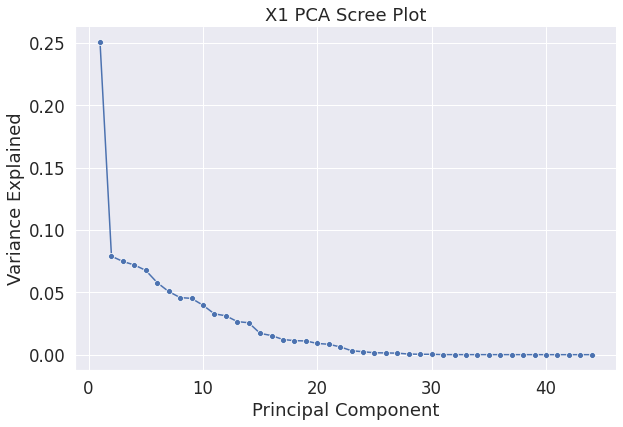

In [35]:
sns.set(font_scale=1.5)
PC_values1 = np.arange(pca.n_components_) + 1
ax1 = sns.relplot(x=PC_values1, y= pca.explained_variance_ratio_, marker='o', kind="line", height=6, aspect=1.5)
ax1.set(xlabel='Principal Component',ylabel = 'Variance Explained', title='X1 PCA Scree Plot' )
ax1.figure.savefig("X4/X1PCA.png")

In [36]:
# print the factors ranking in the order of Eigenvector 
factors = pd.DataFrame({'Factors': X1_normalized.columns, 'Eigenvector 1': pca.components_[0]})
factors = factors.sort_values(by=['Eigenvector 1'], ascending=False)
print(factors)

                                              Factors  Eigenvector 1
35                           Metallurgy and Materials       0.935559
13                                    A1U_since_Sep01       0.034644
12                                    A1C_since_Sep01       0.030715
11                               decision_since_Sep01       0.028155
14                                    A2C_since_Sep01       0.026114
15                                           eng_type       0.024697
3                                         master_prev       0.016647
21                                      Toefl_Overall       0.013696
31                                          multi_app       0.012207
23                                      Toefl_Reading       0.005868
22                                    Toefl_Listening       0.005646
24                                      Toefl_Writing       0.005374
25                                     Toefl_Speaking       0.005061
10                                

In [37]:
pca_fit = pca.fit(X2_normalized)

print('Explained Variance Ratio (%):')
print(pca.explained_variance_ratio_*100)
print('Singular Values:')
print(pca.singular_values_)

Explained Variance Ratio (%):
[2.43837181e+01 8.66755853e+00 7.29602424e+00 7.00192280e+00
 6.62392965e+00 5.62849712e+00 4.93899535e+00 4.45722114e+00
 4.39535431e+00 3.87604185e+00 3.37354685e+00 3.17019170e+00
 2.58379775e+00 2.49453689e+00 1.88697963e+00 1.49148034e+00
 1.21622519e+00 1.17850087e+00 1.08680984e+00 1.04531196e+00
 8.69840185e-01 6.62776987e-01 6.05618758e-01 2.99032892e-01
 2.30261058e-01 1.49426718e-01 1.36900610e-01 1.18461980e-01
 4.82798590e-02 3.17615651e-02 2.82419944e-02 5.09089752e-03
 3.13901524e-03 2.84448719e-03 2.74728218e-03 2.19407520e-03
 1.97681601e-03 1.59966551e-03 1.35554109e-03 1.20460115e-03
 4.32943926e-04 1.68010836e-04 4.34531761e-31 1.63511870e-31
 1.63511870e-31]
Singular Values:
[6.63785570e+01 3.95754839e+01 3.63095592e+01 3.55702160e+01
 3.45967815e+01 3.18914354e+01 2.98742597e+01 2.83798394e+01
 2.81821932e+01 2.64650106e+01 2.46900072e+01 2.39342931e+01
 2.16076283e+01 2.12311153e+01 1.84655160e+01 1.64167283e+01
 1.48246633e+01 1.459

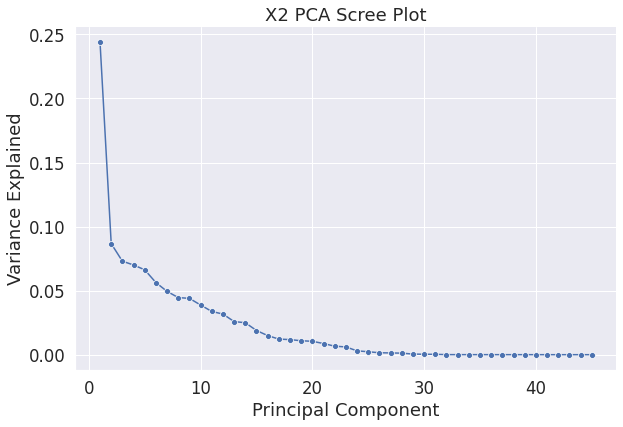

In [38]:
PC_values2 = np.arange(pca.n_components_) + 1
ax2 = sns.relplot(x=PC_values2, y= pca.explained_variance_ratio_, marker='o', kind="line", height=6, aspect=1.5)
ax2.set(xlabel='Principal Component',ylabel = 'Variance Explained',title='X2 PCA Scree Plot')
ax2.figure.savefig("X5/X2PCA.png")

In [39]:
factors = pd.DataFrame({'Factors': X2_normalized.columns, 'Eigenvector 1': pca.components_[0]})
factors = factors.sort_values(by=['Eigenvector 1'], ascending=False)
print(factors)

                                              Factors  Eigenvector 1
36                           Metallurgy and Materials       0.935504
14                                    A1U_since_Sep01       0.034670
13                                    A1C_since_Sep01       0.030755
12                               decision_since_Sep01       0.028104
15                                    A2C_since_Sep01       0.025908
16                                           eng_type       0.024607
4                                         master_prev       0.016477
22                                      Toefl_Overall       0.013668
32                                          multi_app       0.012197
24                                      Toefl_Reading       0.005854
23                                    Toefl_Listening       0.005634
25                                      Toefl_Writing       0.005362
26                                     Toefl_Speaking       0.005051
0                                 

In [40]:
pca_fit = pca.fit(X3_normalized)

print('Explained Variance Ratio (%):')
print(pca.explained_variance_ratio_*100)
print('Singular Values:')
print(pca.singular_values_)

Explained Variance Ratio (%):
[1.59838309e+01 5.54576275e+00 5.23232181e+00 4.83352740e+00
 4.77291293e+00 4.43931059e+00 4.07173391e+00 3.71441166e+00
 3.49244118e+00 3.39070883e+00 3.19476701e+00 3.01551272e+00
 2.73437113e+00 2.63779496e+00 2.47914346e+00 2.25134476e+00
 1.76155038e+00 1.63188181e+00 1.51549279e+00 1.43717376e+00
 1.29732268e+00 1.25808983e+00 1.19796101e+00 1.04203527e+00
 1.01060925e+00 9.46578256e-01 8.87329684e-01 8.23056046e-01
 7.89631889e-01 7.82477919e-01 7.28348648e-01 6.56929798e-01
 6.53687245e-01 6.03959897e-01 5.81775498e-01 5.48559424e-01
 5.36048137e-01 4.98269459e-01 4.44283067e-01 3.93866113e-01
 3.58877406e-01 3.38399008e-01 3.11811174e-01 3.10319559e-01
 3.02498259e-01 2.91718731e-01 2.73421078e-01 2.54483223e-01
 2.51785883e-01 2.45215313e-01 2.31623850e-01 2.27179747e-01
 2.22725259e-01 2.19865147e-01 1.96279515e-01 1.60008812e-01
 1.45844980e-01 1.29926406e-01 1.15968442e-01 1.09811711e-01
 1.07471880e-01 8.66729881e-02 8.31014651e-02 8.0379859

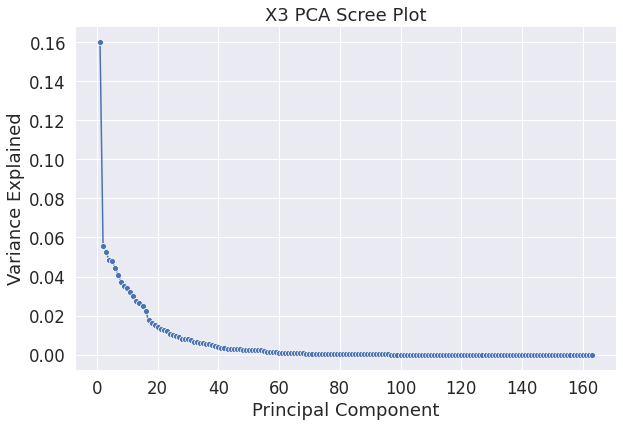

In [41]:
PC_values3 = np.arange(pca.n_components_) + 1
ax3 = sns.relplot(x=PC_values3, y= pca.explained_variance_ratio_, marker='o', kind="line", height=6, aspect=1.5)
ax3.set(xlabel='Principal Component',ylabel = 'Variance Explained',title='X3 PCA Scree Plot')
ax3.figure.savefig("X6/X3PCA.png")

In [42]:
factors = pd.DataFrame({'Factors': X3_normalized.columns, 'Eigenvector 1': pca.components_[0]})
factors = factors.sort_values(by=['Eigenvector 1'], ascending=False)
print(factors)

                                               Factors  Eigenvector 1
35                            Metallurgy and Materials       0.859274
92                       MSc Electric Power Systems PT       0.203442
88                       MSc Computer Science PT (Dub)       0.201201
75                       MSc Civ Eng and Management PT       0.137726
69                          MSc Applied Mathematics FT       0.123491
91     MSc Advanced Chemical Eng with Bioprocessing FT       0.080555
130                     MSc Adv Eng Man (Generalist)PT       0.030369
110                     MSc Rail System Engin Integ DL       0.030348
13                                     A1U_since_Sep01       0.028832
12                                     A1C_since_Sep01       0.025051
11                                decision_since_Sep01       0.024831
14                                     A2C_since_Sep01       0.024573
15                                            eng_type       0.022521
3                   

## 2)Find the most effective features
### 2)1) Univariate Selection

Statistical tests can be used to select those features that have the strongest relationship with the output variable.\
The scikit-learn library provides the SelectKBest class that can be used with a suite of different statistical tests to select a specific number of features.\
Uses the chi-squared (chi²) statistical test for non-negative features to select 10 of the best features from the Dataset.

#### X1: based on PCA elbow plot, pick the first 10 features

In [43]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit1 = bestfeatures.fit(X1_normalized,Y)

# save the transformed X1 set
X1_corela = bestfeatures.transform(X1_normalized)
np.save('X4/X1_corela.npy', X1_corela) # save
#X1_corela = np.load('X1/X1_corela.npy') 

# print the score
featureScores1 = pd.DataFrame({'Feature':X1_normalized.columns, 'Score':fit1.scores_}).sort_values(by=['Score'], ascending=False)
featureScores1.to_csv('X4/featureScores1.csv')
featureScores1.nlargest(10,'Score')

,Feature,Score
14,A2C_since_Sep01,605.814888
35,Metallurgy and Materials,570.053651
37,School of Engineering;Elec Elec and Sys Engine...,175.371904
34,Elec Elec and System Eng;Elec Elec and Sys Eng...,137.498859
32,Computer Science,96.934108
13,A1U_since_Sep01,94.126172
33,Business School,93.367604
42,Wiley,84.806009
38,Mechanical Engineering,73.572804
36,Civil Engineering,69.656512


In [44]:
print(list(featureScores1['Feature'][0:10]))

['A2C_since_Sep01', 'Metallurgy and Materials', 'School of Engineering;Elec Elec and Sys Engineering', 'Elec Elec and System Eng;Elec Elec and Sys Engineering', 'Computer Science', 'A1U_since_Sep01', 'Business School', 'Wiley', 'Mechanical Engineering', 'Civil Engineering']


#### X2: based on PCA elbow plot, pick the first 10 features

In [45]:
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit2 = bestfeatures.fit(X2_normalized,Y)

# save the transformed X2 set
X2_corela = bestfeatures.transform(X2_normalized)
np.save('X5/X2_corela.npy', X2_corela) # save

# print the score
featureScores2 = pd.DataFrame({'Feature':X2_normalized.columns, 'Score':fit2.scores_}).sort_values(by=['Score'], ascending=False)
featureScores2.to_csv('X5/featureScores2.csv')
featureScores2.nlargest(10,'Score')

,Feature,Score
15,A2C_since_Sep01,605.814888
36,Metallurgy and Materials,570.053651
38,School of Engineering;Elec Elec and Sys Engine...,175.371904
35,Elec Elec and System Eng;Elec Elec and Sys Eng...,137.498859
33,Computer Science,96.934108
14,A1U_since_Sep01,94.126172
34,Business School,93.367604
43,Wiley,84.806009
39,Mechanical Engineering,73.572804
37,Civil Engineering,69.656512


In [46]:
print(list(featureScores2['Feature'][0:10]))

['A2C_since_Sep01', 'Metallurgy and Materials', 'School of Engineering;Elec Elec and Sys Engineering', 'Elec Elec and System Eng;Elec Elec and Sys Engineering', 'Computer Science', 'A1U_since_Sep01', 'Business School', 'Wiley', 'Mechanical Engineering', 'Civil Engineering']


#### X3: based on PCA elbow plot, pick the first 20 features

In [47]:
#apply SelectKBest class to extract top 20 best features
bestfeatures = SelectKBest(score_func=chi2, k=20)
fit3 = bestfeatures.fit(X3_normalized,Y)

# save the transformed X3 set
X3_corela = bestfeatures.transform(X3_normalized)
np.save('X6/X3_corela.npy', X3_corela) # save

# print the score
featureScores3 = pd.DataFrame({'Feature':X3_normalized.columns, 'Score':fit3.scores_}).sort_values(by=['Score'], ascending=False)
featureScores3.to_csv('X6/featureScores3.csv')
featureScores3.nlargest(20,'Score')

,Feature,Score
14,A2C_since_Sep01,605.814888
35,Metallurgy and Materials,570.053651
91,MSc Advanced Chemical Eng with Bioprocessing FT,248.783003
69,MSc Applied Mathematics FT,206.793956
37,School of Engineering;Elec Elec and Sys Engine...,175.371904
75,MSc Civ Eng and Management PT,158.420613
34,Elec Elec and System Eng;Elec Elec and Sys Eng...,137.498859
98,MSc Adv Chem Eng w Form FT,136.696422
92,MSc Electric Power Systems PT,129.538554
93,MSc Formulation Engineering FT,105.169212


In [48]:
print(list(featureScores3['Feature'][0:20]))

['A2C_since_Sep01', 'Metallurgy and Materials', 'MSc Advanced Chemical Eng with Bioprocessing FT', 'MSc Applied Mathematics FT', 'School of Engineering;Elec Elec and Sys Engineering', 'MSc Civ Eng and Management PT', 'Elec Elec and System Eng;Elec Elec and Sys Engineering', 'MSc Adv Chem Eng w Form FT', 'MSc Electric Power Systems PT', 'MSc Formulation Engineering FT', 'Computer Science', 'A1U_since_Sep01', 'Business School', 'MSc Geotechnical Eng FT', 'MSc Adv Eng Man (System Man)FT', 'Wiley', 'Mechanical Engineering', 'MSc Road Mgt + Eng FT', 'Civil Engineering', 'A1C_since_Sep01']


### 2)2)Feature Importance with Tree Based Classifiers
Tree Based Classifiers implements a meta estimator that fits a number of randomized decision trees (a.k.a. extra-trees) on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. It can be used to compute impurity-based feature importances.\
Feature importance gives a score for each feature of the data, the higher the score more important or relevant is the feature towards the target variable.\
Here Extra Tree Classifier would extract the top 10 or 20 features for the dataset.

In [49]:
from sklearn.ensemble import ExtraTreesClassifier

tree1 = ExtraTreesClassifier()
tree1.fit(X1_normalized,Y)

feat_importances1 = pd.DataFrame({'feature':X1_normalized.columns, 'value':tree1.feature_importances_}).sort_values(by=['value'], ascending=False)
feat_importances1.to_csv('X4/treeset1.csv')

X1_tree = X1_normalized[list(feat_importances1['feature'])[0:10]]
X1_tree.to_pickle("X4/X1_tree.pkl") 

feat_importances1.nlargest(10,'value')

,feature,value
14,A2C_since_Sep01,0.154208
8,Days at Decision Stage,0.109448
11,decision_since_Sep01,0.087353
13,A1U_since_Sep01,0.071357
0,Applicant ID,0.069810
12,A1C_since_Sep01,0.059732
9,Total Days Admissions,0.056798
10,TOTAL Days,0.056130
6,Days at Admissions Review,0.055942
35,Metallurgy and Materials,0.052050


In [50]:
tree2 = ExtraTreesClassifier()
tree2.fit(X2_normalized,Y)

feat_importances2 = pd.DataFrame({'feature':X2_normalized.columns, 'value':tree2.feature_importances_}).sort_values(by=['value'], ascending=False)

feat_importances2.to_csv('X5/treeset2.csv')

X2_tree = X2_normalized[list(feat_importances1['feature'])[0:10]]
X2_tree.to_pickle("X5/X2_tree.pkl") 

feat_importances2.nlargest(10,'value')

,feature,value
15,A2C_since_Sep01,0.154743
9,Days at Decision Stage,0.105288
12,decision_since_Sep01,0.082901
14,A1U_since_Sep01,0.074626
13,A1C_since_Sep01,0.058259
0,Applicant ID,0.056296
11,TOTAL Days,0.054626
36,Metallurgy and Materials,0.053994
7,Days at Admissions Review,0.051804
10,Total Days Admissions,0.050800


In [51]:
tree3 = ExtraTreesClassifier()
tree3.fit(X3_normalized,Y)

feat_importances3 = pd.DataFrame({'feature':X3_normalized.columns, 'value':tree3.feature_importances_}).sort_values(by=['value'], ascending=False)

feat_importances3.to_csv('X6/treeset3.csv')

X3_tree = X3_normalized[list(feat_importances1['feature'])[0:20]]
X3_tree.to_pickle("X6/X3_tree.pkl") 

feat_importances2.nlargest(20,'value')

,feature,value
15,A2C_since_Sep01,0.154743
9,Days at Decision Stage,0.105288
12,decision_since_Sep01,0.082901
14,A1U_since_Sep01,0.074626
13,A1C_since_Sep01,0.058259
0,Applicant ID,0.056296
11,TOTAL Days,0.054626
36,Metallurgy and Materials,0.053994
7,Days at Admissions Review,0.051804
10,Total Days Admissions,0.050800


# **Modelling**
In this part, each feature set(X1,X2,X3) would go through combinations of methods in each step, to obtain a series of classifiers. \
The steps are:

(1) feature selection\
no selection(X_normalized)\
correlation based(X_corela)\
tree based(X_tree)\

*combine*

(2) modelling\
Logistic Regression\
Naive Bayes\
Random Forest\
Support Vector Machines

# **X1**

## **X1_normalized**

### Split the training set and testing set

In [52]:
from sklearn.model_selection import train_test_split

In [53]:
# split the data in 70:30 for train:test dataset
X_train, X_test, Y_train, Y_test = train_test_split(X1_normalized, Y, test_size = 0.3, random_state = 2, stratify = Y)

### Check the distribution of classes of the target variable, to see whether the data balancing is needed

In [54]:
from collections import Counter
print(f"Training target statistics: {Counter(Y_train)}")
print(f"Testing target statistics: {Counter(Y_test)}")

Training target statistics: Counter({1: 6238, 0: 4684})
Testing target statistics: Counter({1: 2674, 0: 2008})


1.3:1, It turns out that the datased is almost balanced and don't need the balancing

####  Logistic Regression

In [55]:
# Fitting Logistic Regression to the training set
from sklearn.linear_model import LogisticRegression
classifier1 = LogisticRegression(random_state = 0, max_iter=1000)
classifier1.fit(X_train, Y_train)

# Predicting result on test set
Y_pred = classifier1.predict(X_test)

# Report on prediction
from sklearn.metrics import classification_report
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.83      0.70      0.76      2008
           1       0.80      0.89      0.84      2674

    accuracy                           0.81      4682
   macro avg       0.81      0.80      0.80      4682
weighted avg       0.81      0.81      0.81      4682



<AxesSubplot:>

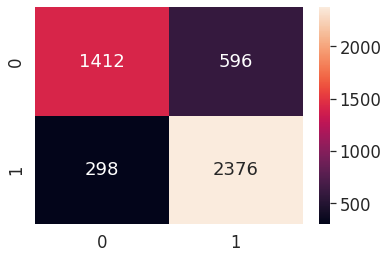

In [56]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(Y_test, Y_pred)
sns.heatmap(cm, annot=True,fmt='d')

####  Naive Bayes

In [57]:
from sklearn.naive_bayes import GaussianNB

classifier2 = GaussianNB()
classifier2.fit(X_train, Y_train)
# Predicting result
Y_pred = classifier2.predict(X_test)
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.59      0.80      0.68      2008
           1       0.79      0.58      0.67      2674

    accuracy                           0.68      4682
   macro avg       0.69      0.69      0.68      4682
weighted avg       0.71      0.68      0.68      4682



### Random Forest

In [58]:
from sklearn.ensemble import RandomForestClassifier

classifier3 = RandomForestClassifier(max_depth=2, random_state=0)

classifier3.fit(X_train, Y_train)
# Predicting result
Y_pred = classifier3.predict(X_test)
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.84      0.57      0.68      2008
           1       0.74      0.92      0.82      2674

    accuracy                           0.77      4682
   macro avg       0.79      0.74      0.75      4682
weighted avg       0.78      0.77      0.76      4682



### Support Vector Machines

In [65]:
from sklearn.svm import SVC
classifier4 = SVC(kernel = 'rbf',random_state = 0)
classifier4.fit(X_train, Y_train)
# Predicting result
Y_pred = classifier4.predict(X_test)
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.84      0.69      0.76      2008
           1       0.79      0.90      0.84      2674

    accuracy                           0.81      4682
   macro avg       0.82      0.80      0.80      4682
weighted avg       0.81      0.81      0.81      4682



#### Conclusion: since the data is lack of balance, the model is not reliable

## **X1_corela**

### Split the training set and testing set

In [66]:
from sklearn.model_selection import train_test_split

In [67]:
# split the data in 70:30 for train:test dataset
X_train, X_test, Y_train, Y_test = train_test_split(X1_corela, Y, test_size = 0.3, random_state = 2, stratify = Y)

### Without balancing

In [68]:
from collections import Counter
print(f"Training target statistics: {Counter(Y_train)}")
print(f"Testing target statistics: {Counter(Y_test)}")

Training target statistics: Counter({1: 6238, 0: 4684})
Testing target statistics: Counter({1: 2674, 0: 2008})


#### Applying Logistic Regression

In [69]:
# Fitting Logistic Regression to the training set
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state = 0, max_iter=1000)
classifier.fit(X_train, Y_train)

# Predicting result on test set
Y_pred = classifier.predict(X_test)

# Report on prediction
from sklearn.metrics import classification_report
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.81      0.68      0.74      2008
           1       0.79      0.88      0.83      2674

    accuracy                           0.80      4682
   macro avg       0.80      0.78      0.79      4682
weighted avg       0.80      0.80      0.79      4682



#Making the Confusion Matrix
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(Y_test, Y_pred)
sns.heatmap(cm, annot=True,fmt='d')

In [70]:
from sklearn.naive_bayes import GaussianNB

classifier = GaussianNB()
classifier.fit(X_train, Y_train)
# Predicting result
Y_pred = classifier.predict(X_test)
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.57      0.72      0.64      2008
           1       0.74      0.60      0.66      2674

    accuracy                           0.65      4682
   macro avg       0.66      0.66      0.65      4682
weighted avg       0.67      0.65      0.65      4682



### Random Forest

In [71]:
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(max_depth=2, random_state=0)

classifier.fit(X_train, Y_train)
# Predicting result
Y_pred = classifier.predict(X_test)
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.79      0.65      0.72      2008
           1       0.77      0.87      0.82      2674

    accuracy                           0.78      4682
   macro avg       0.78      0.76      0.77      4682
weighted avg       0.78      0.78      0.77      4682



#### Support Vector Machines

In [72]:
from sklearn.svm import SVC
classifier = SVC(kernel = 'rbf',random_state = 0)
classifier.fit(X_train, Y_train)
# Predicting result
Y_pred = classifier.predict(X_test)
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.85      0.66      0.74      2008
           1       0.78      0.91      0.84      2674

    accuracy                           0.80      4682
   macro avg       0.82      0.79      0.79      4682
weighted avg       0.81      0.80      0.80      4682



## **X1_tree**

### Split the training set and testing set

In [73]:
from sklearn.model_selection import train_test_split

In [74]:
# split the data in 70:30 for train:test dataset
X_train, X_test, Y_train, Y_test = train_test_split(X1_tree, Y, test_size = 0.3, random_state = 2, stratify = Y)

### Without balancing

In [75]:
from collections import Counter
print(f"Training target statistics: {Counter(Y_train)}")
print(f"Testing target statistics: {Counter(Y_test)}")

Training target statistics: Counter({1: 6238, 0: 4684})
Testing target statistics: Counter({1: 2674, 0: 2008})


#### Applying Logistic Regression

In [76]:
# Fitting Logistic Regression to the training set
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state = 0, max_iter=1000)
classifier.fit(X_train, Y_train)

# Predicting result on test set
Y_pred = classifier.predict(X_test)

# Report on prediction
from sklearn.metrics import classification_report
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.74      0.68      0.71      2008
           1       0.77      0.83      0.80      2674

    accuracy                           0.76      4682
   macro avg       0.76      0.75      0.75      4682
weighted avg       0.76      0.76      0.76      4682



<AxesSubplot:>

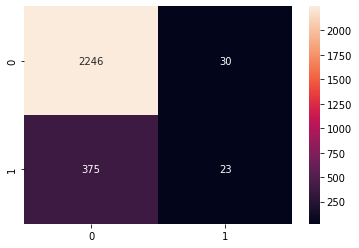

In [53]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(Y_test, Y_pred)
sns.heatmap(cm, annot=True,fmt='d')

In [79]:
from sklearn.naive_bayes import GaussianNB

classifier = GaussianNB()
classifier.fit(X_train, Y_train)
# Predicting result
Y_pred = classifier.predict(X_test)
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.76      0.57      0.65      2008
           1       0.73      0.87      0.79      2674

    accuracy                           0.74      4682
   macro avg       0.75      0.72      0.72      4682
weighted avg       0.74      0.74      0.73      4682



### Random Forest

In [77]:
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(max_depth=2, random_state=0)

classifier.fit(X_train, Y_train)
# Predicting result
Y_pred = classifier.predict(X_test)
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.68      0.86      0.76      2008
           1       0.87      0.70      0.77      2674

    accuracy                           0.77      4682
   macro avg       0.77      0.78      0.77      4682
weighted avg       0.79      0.77      0.77      4682



### Support Vector Machines

In [78]:
from sklearn.svm import SVC
classifier = SVC(kernel = 'rbf',random_state = 0)
classifier.fit(X_train, Y_train)
# Predicting result
Y_pred = classifier.predict(X_test)
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.83      0.67      0.74      2008
           1       0.78      0.89      0.83      2674

    accuracy                           0.80      4682
   macro avg       0.80      0.78      0.79      4682
weighted avg       0.80      0.80      0.79      4682



# X2

X2_normalized\
X2_corela\
X2_tree\

*combine\

LR\
NB\
RF\
SVM\

## X2_normalized

### Split the training set and testing set

In [45]:
from sklearn.model_selection import train_test_split

In [80]:
# split the data in 70:30 for train:test dataset
X_train, X_test, Y_train, Y_test = train_test_split(X2_normalized, Y, test_size = 0.3, random_state = 2, stratify = Y)

## Without balancing

In [81]:
from collections import Counter
print(f"Training target statistics: {Counter(Y_train)}")
print(f"Testing target statistics: {Counter(Y_test)}")

Training target statistics: Counter({1: 6238, 0: 4684})
Testing target statistics: Counter({1: 2674, 0: 2008})


#### Applying Logistic Regression

In [82]:
# Fitting Logistic Regression to the training set
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state = 0, max_iter=1000)
classifier.fit(X_train, Y_train)

# Predicting result on test set
Y_pred = classifier.predict(X_test)

# Report on prediction
from sklearn.metrics import classification_report
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.83      0.70      0.76      2008
           1       0.80      0.89      0.84      2674

    accuracy                           0.81      4682
   macro avg       0.81      0.80      0.80      4682
weighted avg       0.81      0.81      0.81      4682



<AxesSubplot:>

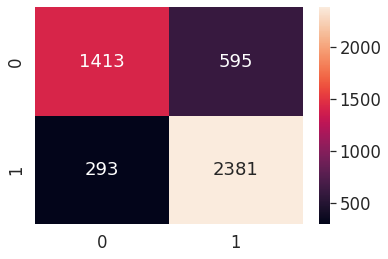

In [83]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(Y_test, Y_pred)
sns.heatmap(cm, annot=True,fmt='d')

In [84]:
from sklearn.naive_bayes import GaussianNB

classifier = GaussianNB()
classifier.fit(X_train, Y_train)
# Predicting result
Y_pred = classifier.predict(X_test)
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.59      0.80      0.68      2008
           1       0.79      0.58      0.67      2674

    accuracy                           0.67      4682
   macro avg       0.69      0.69      0.67      4682
weighted avg       0.70      0.67      0.67      4682



### Random Forest

In [85]:
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(max_depth=2, random_state=0)

classifier.fit(X_train, Y_train)
# Predicting result
Y_pred = classifier.predict(X_test)
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.84      0.58      0.68      2008
           1       0.74      0.92      0.82      2674

    accuracy                           0.77      4682
   macro avg       0.79      0.75      0.75      4682
weighted avg       0.78      0.77      0.76      4682



### SVM

In [86]:
from sklearn.svm import SVC
classifier = SVC(kernel = 'rbf',random_state = 0)
classifier.fit(X_train, Y_train)
# Predicting result
Y_pred = classifier.predict(X_test)
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.84      0.68      0.75      2008
           1       0.79      0.90      0.84      2674

    accuracy                           0.81      4682
   macro avg       0.82      0.79      0.80      4682
weighted avg       0.81      0.81      0.81      4682



## X2_corela

### Split the training set and testing set

In [87]:
from sklearn.model_selection import train_test_split

In [88]:
# split the data in 70:30 for train:test dataset
X_train, X_test, Y_train, Y_test = train_test_split(X2_corela, Y, test_size = 0.3, random_state = 2, stratify = Y)

## Without balancing

In [89]:
from collections import Counter
print(f"Training target statistics: {Counter(Y_train)}")
print(f"Testing target statistics: {Counter(Y_test)}")

Training target statistics: Counter({1: 6238, 0: 4684})
Testing target statistics: Counter({1: 2674, 0: 2008})


#### Applying Logistic Regression

In [90]:
# Fitting Logistic Regression to the training set
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state = 0, max_iter=1000)
classifier.fit(X_train, Y_train)

# Predicting result on test set
Y_pred = classifier.predict(X_test)

# Report on prediction
from sklearn.metrics import classification_report
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.81      0.68      0.74      2008
           1       0.79      0.88      0.83      2674

    accuracy                           0.80      4682
   macro avg       0.80      0.78      0.79      4682
weighted avg       0.80      0.80      0.79      4682



<AxesSubplot:>

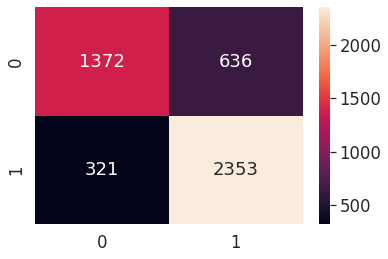

In [91]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(Y_test, Y_pred)
sns.heatmap(cm, annot=True,fmt='d')

In [92]:
from sklearn.naive_bayes import GaussianNB

classifier = GaussianNB()
classifier.fit(X_train, Y_train)
# Predicting result
Y_pred = classifier.predict(X_test)
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.57      0.72      0.64      2008
           1       0.74      0.60      0.66      2674

    accuracy                           0.65      4682
   macro avg       0.66      0.66      0.65      4682
weighted avg       0.67      0.65      0.65      4682



### Random Forest

In [93]:
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(max_depth=2, random_state=0)

classifier.fit(X_train, Y_train)
# Predicting result
Y_pred = classifier.predict(X_test)
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.79      0.65      0.72      2008
           1       0.77      0.87      0.82      2674

    accuracy                           0.78      4682
   macro avg       0.78      0.76      0.77      4682
weighted avg       0.78      0.78      0.77      4682



### SVM

In [94]:
from sklearn.svm import SVC
classifier = SVC(kernel = 'rbf',random_state = 0)
classifier.fit(X_train, Y_train)
# Predicting result
Y_pred = classifier.predict(X_test)
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.85      0.66      0.74      2008
           1       0.78      0.91      0.84      2674

    accuracy                           0.80      4682
   macro avg       0.82      0.79      0.79      4682
weighted avg       0.81      0.80      0.80      4682



## X2_tree

### Split the training set and testing set

In [188]:
from sklearn.model_selection import train_test_split

In [95]:
# split the data in 70:30 for train:test dataset
X_train, X_test, Y_train, Y_test = train_test_split(X2_tree, Y, test_size = 0.3, random_state = 2, stratify = Y)

## Without balancing

In [96]:
from collections import Counter
print(f"Training target statistics: {Counter(Y_train)}")
print(f"Testing target statistics: {Counter(Y_test)}")

Training target statistics: Counter({1: 6238, 0: 4684})
Testing target statistics: Counter({1: 2674, 0: 2008})


#### Applying Logistic Regression

In [97]:
# Fitting Logistic Regression to the training set
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state = 0, max_iter=1000)
classifier.fit(X_train, Y_train)

# Predicting result on test set
Y_pred = classifier.predict(X_test)

# Report on prediction
from sklearn.metrics import classification_report
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.74      0.68      0.71      2008
           1       0.77      0.83      0.80      2674

    accuracy                           0.76      4682
   macro avg       0.76      0.75      0.75      4682
weighted avg       0.76      0.76      0.76      4682



<AxesSubplot:>

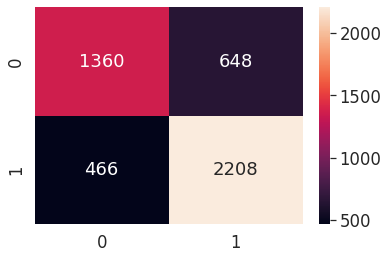

In [98]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(Y_test, Y_pred)
sns.heatmap(cm, annot=True,fmt='d')

In [99]:
from sklearn.naive_bayes import GaussianNB

classifier = GaussianNB()
classifier.fit(X_train, Y_train)
# Predicting result
Y_pred = classifier.predict(X_test)
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.76      0.57      0.65      2008
           1       0.73      0.87      0.79      2674

    accuracy                           0.74      4682
   macro avg       0.75      0.72      0.72      4682
weighted avg       0.74      0.74      0.73      4682



### Random Forest

In [100]:
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(max_depth=2, random_state=0)

classifier.fit(X_train, Y_train)
# Predicting result
Y_pred = classifier.predict(X_test)
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.68      0.86      0.76      2008
           1       0.87      0.70      0.77      2674

    accuracy                           0.77      4682
   macro avg       0.77      0.78      0.77      4682
weighted avg       0.79      0.77      0.77      4682



### SVM

In [101]:
from sklearn.svm import SVC
classifier = SVC(kernel = 'rbf',random_state = 0)
classifier.fit(X_train, Y_train)
# Predicting result
Y_pred = classifier.predict(X_test)
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.83      0.67      0.74      2008
           1       0.78      0.89      0.83      2674

    accuracy                           0.80      4682
   macro avg       0.80      0.78      0.79      4682
weighted avg       0.80      0.80      0.79      4682



# X3

X3_normalized\
X3_corela\
X3_tree\


*combine\

LR\
NB\
RF\
SVM\

## X3_normalized

### Split the training set and testing set

In [102]:
from sklearn.model_selection import train_test_split

In [103]:
# split the data in 70:30 for train:test dataset
X_train, X_test, Y_train, Y_test = train_test_split(X3_normalized, Y, test_size = 0.3, random_state = 2, stratify = Y)

## Without balancing

In [104]:
from collections import Counter
print(f"Training target statistics: {Counter(Y_train)}")
print(f"Testing target statistics: {Counter(Y_test)}")

Training target statistics: Counter({1: 6238, 0: 4684})
Testing target statistics: Counter({1: 2674, 0: 2008})


#### Applying Logistic Regression

In [105]:
# Fitting Logistic Regression to the training set
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state = 0, max_iter=1000)
classifier.fit(X_train, Y_train)

# Predicting result on test set
Y_pred = classifier.predict(X_test)

# Report on prediction
from sklearn.metrics import classification_report
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.84      0.72      0.77      2008
           1       0.81      0.89      0.85      2674

    accuracy                           0.82      4682
   macro avg       0.82      0.81      0.81      4682
weighted avg       0.82      0.82      0.82      4682



<AxesSubplot:>

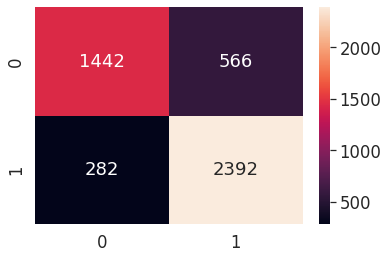

In [106]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(Y_test, Y_pred)
sns.heatmap(cm, annot=True,fmt='d')

In [107]:
from sklearn.naive_bayes import GaussianNB

classifier = GaussianNB()
classifier.fit(X_train, Y_train)
# Predicting result
Y_pred = classifier.predict(X_test)
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.75      0.40      0.52      2008
           1       0.67      0.90      0.77      2674

    accuracy                           0.69      4682
   macro avg       0.71      0.65      0.64      4682
weighted avg       0.70      0.69      0.66      4682



### Random Forest

In [108]:
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(max_depth=2, random_state=0)

classifier.fit(X_train, Y_train)
# Predicting result
Y_pred = classifier.predict(X_test)
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.82      0.37      0.51      2008
           1       0.66      0.94      0.78      2674

    accuracy                           0.69      4682
   macro avg       0.74      0.65      0.64      4682
weighted avg       0.73      0.69      0.66      4682



### SVM

In [109]:
from sklearn.svm import SVC
classifier = SVC(kernel = 'rbf',random_state = 0)
classifier.fit(X_train, Y_train)
# Predicting result
Y_pred = classifier.predict(X_test)
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.89      0.68      0.77      2008
           1       0.79      0.93      0.86      2674

    accuracy                           0.82      4682
   macro avg       0.84      0.81      0.81      4682
weighted avg       0.83      0.82      0.82      4682



## X3_corela

### Split the training set and testing set

In [353]:
from sklearn.model_selection import train_test_split

In [110]:
# split the data in 70:30 for train:test dataset
X_train, X_test, Y_train, Y_test = train_test_split(X3_corela, Y, test_size = 0.3, random_state = 2, stratify = Y)

## Without balancing

In [111]:
from collections import Counter
print(f"Training target statistics: {Counter(Y_train)}")
print(f"Testing target statistics: {Counter(Y_test)}")

Training target statistics: Counter({1: 6238, 0: 4684})
Testing target statistics: Counter({1: 2674, 0: 2008})


#### Applying Logistic Regression

In [112]:
# Fitting Logistic Regression to the training set
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state = 0, max_iter=1000)
classifier.fit(X_train, Y_train)

# Predicting result on test set
Y_pred = classifier.predict(X_test)

# Report on prediction
from sklearn.metrics import classification_report
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.83      0.68      0.75      2008
           1       0.79      0.89      0.84      2674

    accuracy                           0.80      4682
   macro avg       0.81      0.79      0.79      4682
weighted avg       0.81      0.80      0.80      4682



<AxesSubplot:>

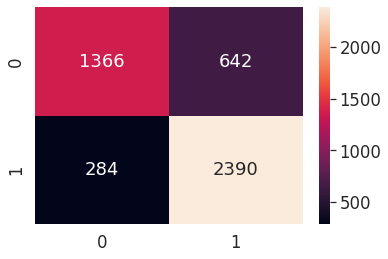

In [113]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(Y_test, Y_pred)
sns.heatmap(cm, annot=True,fmt='d')

In [114]:
from sklearn.naive_bayes import GaussianNB

classifier = GaussianNB()
classifier.fit(X_train, Y_train)
# Predicting result
Y_pred = classifier.predict(X_test)
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.59      0.73      0.65      2008
           1       0.75      0.61      0.67      2674

    accuracy                           0.66      4682
   macro avg       0.67      0.67      0.66      4682
weighted avg       0.68      0.66      0.66      4682



### Random Forest

In [115]:
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(max_depth=2, random_state=0)

classifier.fit(X_train, Y_train)
# Predicting result
Y_pred = classifier.predict(X_test)
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.82      0.60      0.69      2008
           1       0.75      0.90      0.82      2674

    accuracy                           0.77      4682
   macro avg       0.78      0.75      0.76      4682
weighted avg       0.78      0.77      0.76      4682



### SVM

In [116]:
from sklearn.svm import SVC
classifier = SVC(kernel = 'rbf',random_state = 0)
classifier.fit(X_train, Y_train)
# Predicting result
Y_pred = classifier.predict(X_test)
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.85      0.66      0.74      2008
           1       0.78      0.91      0.84      2674

    accuracy                           0.80      4682
   macro avg       0.82      0.79      0.79      4682
weighted avg       0.81      0.80      0.80      4682



## X3_tree

### Split the training set and testing set

In [321]:
from sklearn.model_selection import train_test_split

In [117]:
# split the data in 70:30 for train:test dataset
X_train, X_test, Y_train, Y_test = train_test_split(X3_tree, Y, test_size = 0.3, random_state = 2, stratify = Y)

## Without balancing

In [118]:
from collections import Counter
print(f"Training target statistics: {Counter(Y_train)}")
print(f"Testing target statistics: {Counter(Y_test)}")

Training target statistics: Counter({1: 6238, 0: 4684})
Testing target statistics: Counter({1: 2674, 0: 2008})


#### Applying Logistic Regression

In [119]:
# Fitting Logistic Regression to the training set
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state = 0, max_iter=1000)
classifier.fit(X_train, Y_train)

# Predicting result on test set
Y_pred = classifier.predict(X_test)

# Report on prediction
from sklearn.metrics import classification_report
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.81      0.69      0.74      2008
           1       0.79      0.88      0.83      2674

    accuracy                           0.80      4682
   macro avg       0.80      0.78      0.79      4682
weighted avg       0.80      0.80      0.79      4682



<AxesSubplot:>

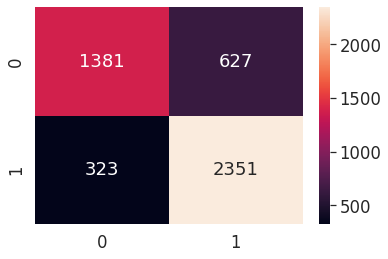

In [120]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(Y_test, Y_pred)
sns.heatmap(cm, annot=True,fmt='d')

In [121]:
from sklearn.naive_bayes import GaussianNB

classifier = GaussianNB()
classifier.fit(X_train, Y_train)
# Predicting result
Y_pred = classifier.predict(X_test)
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.67      0.71      0.69      2008
           1       0.77      0.73      0.75      2674

    accuracy                           0.72      4682
   macro avg       0.72      0.72      0.72      4682
weighted avg       0.73      0.72      0.72      4682



### Random Forest

In [122]:
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(max_depth=2, random_state=0)

classifier.fit(X_train, Y_train)
# Predicting result
Y_pred = classifier.predict(X_test)
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.79      0.79      0.79      2008
           1       0.84      0.84      0.84      2674

    accuracy                           0.82      4682
   macro avg       0.82      0.82      0.82      4682
weighted avg       0.82      0.82      0.82      4682



### SVM

In [123]:
from sklearn.svm import SVC
classifier = SVC(kernel = 'rbf',random_state = 0)
classifier.fit(X_train, Y_train)
# Predicting result
Y_pred = classifier.predict(X_test)
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.82      0.69      0.75      2008
           1       0.79      0.89      0.84      2674

    accuracy                           0.80      4682
   macro avg       0.81      0.79      0.79      4682
weighted avg       0.80      0.80      0.80      4682

